In [1]:
# Script to test out different parameters and see what effect this has on the model

import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pandas.io.stata import StataParser
from pytrends.request import TrendReq
import time
import pandas as pd
import matplotlib
import google_trends_daily.gtrend as gtrend

from sklearn.model_selection import train_test_split
import platform

import RF
import lstm
import linear
import postprocessing
import platform
# Making a new preprocessing file so I can mess with the inputs/outputs
import preprocessing_for_variation as prep


In [11]:

# Just for reference for the JHU data files
startOfCovid = '1/22/20' # The first day where data has been recorded
endOfCovid = '10/30/21' # The last day of relevance to this project
# NOTE delay can be a maximum of 30 because of this end date and the way I load all the data at once

# Step 1: Get the trends data for a very large timeframe so we can pre-load this and not web-scrape each time

xDateFormat = '%Y-%m-%d'
if platform.system() == 'Windows':
    yDateFormat = '%#m/%#d/%y'
else:
    yDateFormat = '%-m/%-d/%y'

# Using a delay of 16 days
startDateX = '2020-03-01'
endDateX = '2021-06-01'
delay = timedelta(days=8)
startDateY = (datetime.strptime(startDateX, xDateFormat) + delay).strftime(xDateFormat) # these should be in xdate format
endDateY = (datetime.strptime(endDateX, xDateFormat) + delay).strftime(xDateFormat)
geo = 'US-CA'
state = 'California'


X_all, Y_all_6delay, Y_all = prep.getDataNew(startDateX, endDateX, startDateY, endDateY, geo, state)
# X_all is the search term data for the entire giant period
# Y_all_6delay is the case data for the entire period, with the delay included


Fetching 'covid' for period:2020-09-05 2021-06-01
Fetching 'covid' for period:2020-03-20 2020-12-14
Normalize by overlapping period:2020-09-05 2020-12-14
Fetching 'covid' for period:2019-10-03 2020-06-28
Normalize by overlapping period:2020-03-20 2020-06-28
Fetching 'coronavirus' for period:2020-09-05 2021-06-01
Fetching 'coronavirus' for period:2020-03-20 2020-12-14
Normalize by overlapping period:2020-09-05 2020-12-14
Fetching 'coronavirus' for period:2019-10-03 2020-06-28
Normalize by overlapping period:2020-03-20 2020-06-28
Fetching 'covid-19' for period:2020-09-05 2021-06-01
Fetching 'covid-19' for period:2020-03-20 2020-12-14
Normalize by overlapping period:2020-09-05 2020-12-14
Fetching 'covid-19' for period:2019-10-03 2020-06-28
Normalize by overlapping period:2020-03-20 2020-06-28
Fetching 'covid cases' for period:2020-09-05 2021-06-01
Fetching 'covid cases' for period:2020-03-20 2020-12-14
Normalize by overlapping period:2020-09-05 2020-12-14
Fetching 'covid cases' for period

In [12]:

# Indexing this by date as well:
sdate = datetime.strptime(startDateX, xDateFormat)
edate = datetime.strptime(endDateX, xDateFormat)
dates = pd.date_range(sdate,edate,freq='d')
dateList = dates.strftime(xDateFormat).to_list()
X_all_dateIndexed = X_all.copy(deep=True)
X_all_dateIndexed['dates'] = dateList
X_all_dateIndexed = X_all_dateIndexed.set_index('dates')
# Y is already indexed by date, but needs to be converted to datetime form
Y_all_6delay.index = pd.to_datetime(Y_all_6delay.index)
Y_all.index = pd.to_datetime(Y_all.index)



In [17]:
# ABLATION ##################################
# Set parameters

queries = ['covid', 'coronavirus', 'covid-19', 'covid cases', 'coronavirus cases', 'covid symptoms', 
'coronavirus symptoms', 'cough', 'virus', 'vaccine', 'covid vaccine']

startDate_subset_X = '2020-03-01'
endDate_subset_X = '2020-06-01'
startDate_subset_Y = '3/09/20'
endDate_subset_Y = '6/09/20'

train_percentage = 0.844444

In [18]:
# ABLATION CONTINUED ###########################
# Run the original comparison model

# Get the subset of data corresponding to our date range
X = X_all_dateIndexed[startDate_subset_X:endDate_subset_X]
Y = Y_all[startDate_subset_Y:endDate_subset_Y]

# Get the train/test split percent
split_idx = round(len(Y)*train_percentage)
# Run our models
# Linear regression
linear_predict = linear.linear(X, Y, train_percentage)
linear_rms = postprocessing.MAPE(Y[split_idx:], linear_predict)
# LSTM
lstm_predict = lstm.lstm(X, Y, train_percentage)
lstm_rms = postprocessing.MAPE(Y[split_idx:], lstm_predict)
# RF
RF_kwargs = {'bootstrap': True,'criterion': 'squared_error','max_depth': None,'min_samples_leaf': 1,'n_estimators': 1000,'min_samples_split': 2,'random_state': 0 }
RFmodel, RF_predict = RF.randomForest(X[:split_idx], X[split_idx:], Y[:split_idx], RF_kwargs)
RF_rms = postprocessing.MAPE(Y[split_idx:], RF_predict)

unablated_linear = linear_rms
unablated_lstm = lstm_rms
unablated_RF = RF_rms


(93, 11)
(79, 11)
(14, 11)
Epoch 1/200
1/1 - 3s - loss: 0.6207 - val_loss: 0.8361 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 0.5993 - val_loss: 0.8238 - 36ms/epoch - 36ms/step
Epoch 3/200
1/1 - 0s - loss: 0.5778 - val_loss: 0.8115 - 37ms/epoch - 37ms/step
Epoch 4/200
1/1 - 0s - loss: 0.5568 - val_loss: 0.7992 - 40ms/epoch - 40ms/step
Epoch 5/200
1/1 - 0s - loss: 0.5362 - val_loss: 0.7868 - 47ms/epoch - 47ms/step
Epoch 6/200
1/1 - 0s - loss: 0.5157 - val_loss: 0.7745 - 47ms/epoch - 47ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4950 - val_loss: 0.7621 - 38ms/epoch - 38ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4743 - val_loss: 0.7496 - 44ms/epoch - 44ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4534 - val_loss: 0.7371 - 44ms/epoch - 44ms/step
Epoch 10/200
1/1 - 0s - loss: 0.4325 - val_loss: 0.7245 - 37ms/epoch - 37ms/step
Epoch 11/200
1/1 - 0s - loss: 0.4113 - val_loss: 0.7118 - 143ms/epoch - 143ms/step
Epoch 12/200
1/1 - 0s - loss: 0.3900 - val_loss: 0.6991 - 35ms/epoch - 35ms/step
Epoch 13/200

In [19]:
def pctDiff(a,b):
    return abs(2*(a-b)/(a+b))

In [35]:
# DEBUG
numcols

11

In [21]:

# ABLATION CONTINUED ###########################
# Run the 


# Get the number of columns in the data (number of search queries)
# Loop over this number
# Eliminate that column of data
# Run the models
# Save the data 

ablationData = []

numcols = len(queries)
for i in range(numcols):
    # Copy the original data and then drop one of the columns
    X_mod = X_all_dateIndexed.copy()
    X_mod.drop(queries[i], axis=1)

    # Get the subset of data corresponding to our date range
    X = X_mod[startDate_subset_X:endDate_subset_X]
    Y = Y_all[startDate_subset_Y:endDate_subset_Y]

    # Get the train/test split percent
    split_idx = round(len(Y)*train_percentage)
    # Run our models
    # Linear regression
    linear_predict = linear.linear(X, Y, train_percentage)
    linear_rms = postprocessing.MAPE(Y[split_idx:], linear_predict)
    # LSTM
    lstm_predict = lstm.lstm(X, Y, train_percentage)
    lstm_rms = postprocessing.MAPE(Y[split_idx:], lstm_predict)
    # RF
    RF_kwargs = {'bootstrap': True,'criterion': 'squared_error','max_depth': None,'min_samples_leaf': 1,'n_estimators': 1000,'min_samples_split': 2,'random_state': 0 }
    RFmodel, RF_predict = RF.randomForest(X[:split_idx], X[split_idx:], Y[:split_idx], RF_kwargs)
    RF_rms = postprocessing.MAPE(Y[split_idx:], RF_predict)

    # Save the data. 
    ablationData.append([queries[i], pctDiff(linear_rms, unablated_linear), pctDiff(lstm_rms, unablated_lstm), pctDiff(RF_rms, unablated_RF)])

(93, 11)
(79, 11)
(14, 11)
Epoch 1/200
1/1 - 3s - loss: 0.5903 - val_loss: 0.8352 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 0.5701 - val_loss: 0.8231 - 29ms/epoch - 29ms/step
Epoch 3/200
1/1 - 0s - loss: 0.5499 - val_loss: 0.8109 - 32ms/epoch - 32ms/step
Epoch 4/200
1/1 - 0s - loss: 0.5297 - val_loss: 0.7988 - 41ms/epoch - 41ms/step
Epoch 5/200
1/1 - 0s - loss: 0.5095 - val_loss: 0.7867 - 41ms/epoch - 41ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4892 - val_loss: 0.7745 - 40ms/epoch - 40ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4689 - val_loss: 0.7623 - 39ms/epoch - 39ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4485 - val_loss: 0.7501 - 43ms/epoch - 43ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4280 - val_loss: 0.7377 - 37ms/epoch - 37ms/step
Epoch 10/200
1/1 - 0s - loss: 0.4074 - val_loss: 0.7254 - 47ms/epoch - 47ms/step
Epoch 11/200
1/1 - 0s - loss: 0.3867 - val_loss: 0.7129 - 46ms/epoch - 46ms/step
Epoch 12/200
1/1 - 0s - loss: 0.3663 - val_loss: 0.7004 - 44ms/epoch - 44ms/step
Epoch 13/200
1

Text(0.5, 1.0, 'Ablation study on search queries')

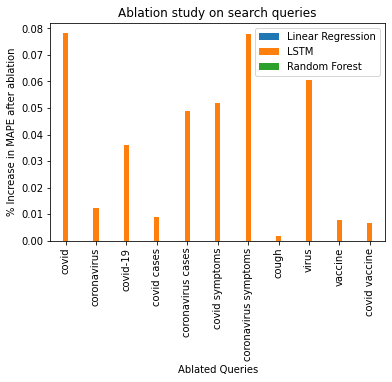

In [22]:
ablation_df = pd.DataFrame(ablationData, columns=['Ablated Queries', 'Linear Regression', 'LSTM', 'Random Forest'])
ablation_df = ablation_df.set_index('Ablated Queries')
#ablation_df.style.set_caption('Varying the Train/Test Split (Train Percentage): Effects on MAPE')
ax = ablation_df.plot.bar()
ax.set_ylabel("% Increase in MAPE after ablation")
ax.set_title('Ablation study on search queries')

# TO-DO
# Change the yticks to actually percentages!!
# Figure out what's the deal with the ablation having no effect on linear regression/RF



In [23]:
import matplotlib.ticker as mtick

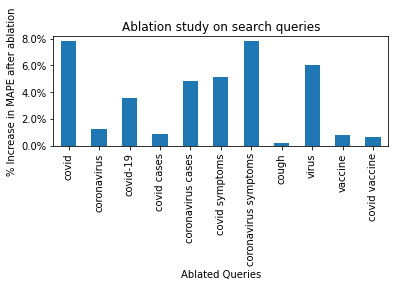

In [25]:
# Ablation plot with only the LSTM info
ablation_lstm_only = ablation_df['LSTM']
ablation_lstm_only = pd.DataFrame(ablation_lstm_only)
ax = ablation_lstm_only.plot.bar(legend=None)
ax.set_ylabel("% Increase in MAPE after ablation")
ax.set_title('Ablation study on search queries')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig("plots/ablation.pdf")

In [ ]:
# DEBUG
